* 泰坦尼克灾难是kaggle的经典题目，这里结合我之前对这个题目的经验和后续参考其他大牛的分析方法，做一个汇总，希望能达到**Top3%**的水平。
* 之前尝试过对空值的进行处理（包括对年龄字段进行拟合），并且做了不少的特征工程，得到的结果往往是在cross validation中可以获得约0.85左右的得分，但是在test集中降到0.76左右。
* 后来参考过了其他同学的一些建议，发现这是一个过拟合的现象，train集和test集有一定的偏差，所以还是需要做一些特征筛选。
* 在调研过程中，有一位大牛通过对age、freq(ticket、fare和cabin的)、familysize对乘客进行**分群**，然后结合pclass和sex的条件存活概率计算log likelihood值，最后针对不同的群，对对应的log likelihood进行加权或惩罚，最后仅使用这一个特征进行预测，预测结果在样本内验证集上约0.83左右的分值，在测试集上也可以达到约0.82左右的分值，泛化效果很好。原版：https://www.kaggle.com/pliptor/divide-and-conquer-0-82296 python版：https://www.kaggle.com/krasserm/divide-and-conquer-in-python-0-82296
* 另一位做了很多和我之前类似的特征工程，但是做了特征选择，据其文档描述也达到了0.81左右的分数，

分析步骤：
- 数据基本概况
- 空值处理
- 特征工程

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

%matplotlib inline
sns.set_style("whitegrid")

## 数据基本概况

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

以下是官方提供的数据维度解释
* survival	Survival/y变量	0 = No, 1 = Yes
* pclass	Ticket class/船票等级	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	Sex/性别	
* Age	Age in years/年龄	
* sibsp	# of siblings / spouses aboard the Titanic/同船的同胞兄弟和配偶数
* parch	# of parents / children aboard the Titanic/同船的子女和父母数
* ticket	Ticket number/ 票号
* fare	Passenger fare/　费用(后经调研，为家庭总费用)
* cabin	Cabin number/　船舱号
* embarked	Port of Embarkation/登船的港口

In [3]:
# 删除离群点
# 返回离群点的index
# df: 数据
# n: 当某行数据有大于n个离群点，则drop
# columns: 字段
def delect_outliers(df, n, columns):
    outliers_index = []
    for c in columns:
        q1 = np.percentile(df[c], 25)
        q3 = np.percentile(df[c], 75)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr
        
        outliers = df[(df[c]<q1-outlier_step) | (df[c]>q3+outlier_step)].index
        outliers_index.extend(outliers)
    delete_target = Counter(outliers_index)
    indexes = [i for i, v in delete_target.items() if v > n]
    return indexes

outliers_index = delect_outliers(train, 2, ['Pclass', 'Fare', 'SibSp', 'Parch'])
train.drop(outliers_index, axis=0, inplace=True)
train_len = train.shape[0]

In [3]:
def show_count_ratio(data, x, y, xsize, ysize):
    fig = plt.figure(figsize=(xsize, ysize))
    ax = fig.add_subplot(111)
    ax.set_xticklabels(data[x].values, rotation=45)
    ax2 = ax.twinx()
    a1 = sns.countplot(data=data, x=x, ax=ax, palette='colorblind', alpha=0.7)
    a2 = sns.pointplot(data=data, x=x, y=y, ci=None, scale=0.8, ax=ax2, alpha=0.8)
    ax2.set_ylim((0,0.8))
    ax.legend(['count'],loc=(.75,.90), fontsize=15)
    ax2.legend(['ratio'],loc=(.75, .85), fontsize=15)
    
    ax.grid(False)
    ax2.grid(False)
    plt.show()

In [17]:
combined = pd.concat([train, test], axis=0, ignore_index=True)
combined_test = combined.copy()

In [18]:
print(u'空值情况')
train.isnull().sum()

空值情况


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- Age字段缺失170，如果进行拟合可能会变成噪声，可以构造是否有年龄这一特征，同时对有年龄的乘客中进行一些分析。  
- Cabin字段缺失太多，暂时不做填充
- Embarked字段可以用多数值填补

## 数据探索&特征工程

### Age & Pclass
* 看下0/1乘客的年龄分布，可以发现14岁一下的乘客的存活率相对较高
* 结合pclass和sex条件下看年龄的分布
* 又可以发现，pclass为2和3下，年龄小于14的乘客存活率相对其他更高
* 结合以上观点，针对p2和p3的年龄小于14的乘客做做文章

(0, 0.04)

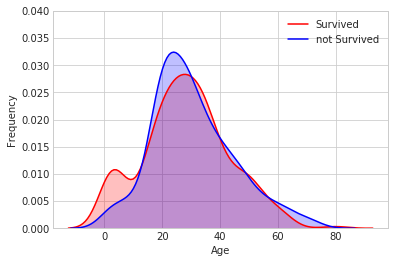

In [19]:
g = sns.kdeplot(train[(train.Survived==1)&(train['Age'].notnull())]['Age'], 
                color='Red', shade=True)
g = sns.kdeplot(train[(train.Survived==0)&(train['Age'].notnull())]['Age'], 
                color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g.legend(['Survived', 'not Survived'])
g.set_ylim(0, 0.04)

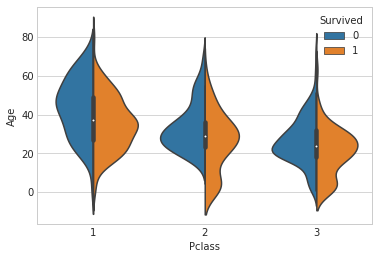

In [20]:
sns.violinplot(data=train, x='Pclass', y='Age', hue='Survived', split=True)

In [21]:
# 对于p2和p3中小于14岁的乘客打标
combined_test['Child'] = combined_test.loc[:,'Age'] < 14

### Pclass & Sex
- 看一下Pclass和Sex的条件分布

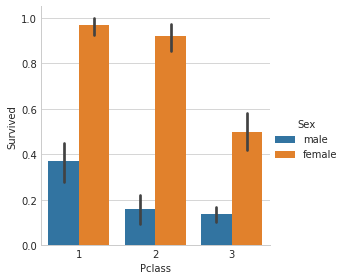

In [22]:
g = sns.factorplot(data=combined_test, x='Pclass', y='Survived', hue='Sex', kind='bar')

* 上图中可以发现，女乘客的存活率远高于男乘客。
* 但是p3中，女乘客的存活率，相比p1和p2低很多，接近50%左右
* 同时，p1的男乘客的存活率，相对与p2和p3高很多
* 构建log likelyhood特征

In [23]:
# log(p/(1-p)) -> lr表达式
def log_lr(x):
    a = max(x, 0.01)
    a = min(x, 0.99)
    return np.log(a/(1-a))

In [24]:
survived_rate = train.groupby(['Pclass', 'Sex']).Survived.mean()
survived_rate

combined_test['SLogR'] = combined_test.apply(lambda x: log_lr(survived_rate[x.Pclass, x.Sex]), axis=1)

- 看下SLogR变量与Surivived的相关性

In [25]:
combined_test[['Survived', 'SLogR']].corr()

,Survived,SLogR
Survived,1.000000,0.623948
SLogR,0.623948,1.000000


### Family信息，涉及Name|Parch|SibSp
* 提取每位乘客的first name
* 每位乘客的家庭人数

In [26]:
def first_name(name):
    return name.split(',')[0].strip()
combined_test['FirstName'] = combined_test['Name'].map(first_name)
combined_test['FamilySize'] = combined_test['Parch'] + combined_test['SibSp'] + 1

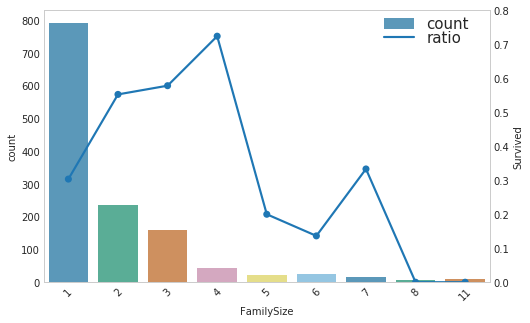

In [28]:
show_count_ratio(combined_test, 'FamilySize', 'Survived', 8, 5)

### Frequency，看下FirstName|Fare|Ticket|Cabin出现频次

In [30]:
for column in ['FirstName','Fare','Ticket','Cabin']:
    freq_name = column + 'Freq'
    freq = combined_test[column].value_counts().to_frame()
    freq.columns = [freq_name]
    combined_test[freq_name] = combined_test.merge(freq, how='left', left_on=column, right_index=True)[freq_name]

In [31]:
def TicketFreqLevel(x):
    if x >= 2 and x <= 4:
        return 2
    else:
        return 1
combined_test['TicketFreqLevel'] = combined_test.TicketFreq.map(TicketFreqLevel)

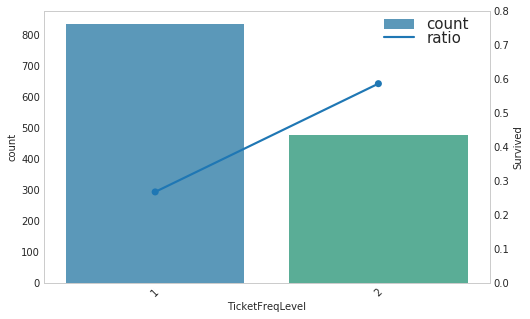

In [32]:
show_count_ratio(combined_test, 'TicketFreqLevel', 'Survived', 8, 5)

In [33]:
combined_test[['Survived', 'TicketFreqLevel']].corr()

,Survived,TicketFreqLevel
Survived,1.000000,0.315591
TicketFreqLevel,0.315591,1.000000


- 下图是FareFreq的分布和存活概率，貌似没看出什么规律

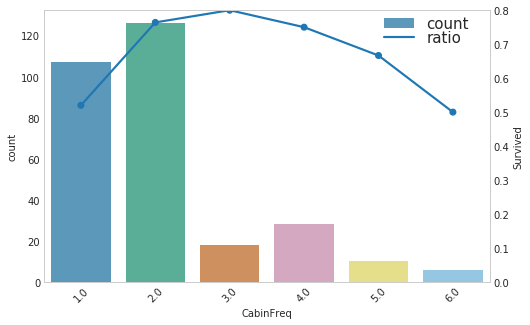

In [34]:
show_count_ratio(combined_test, 'CabinFreq', 'Survived', 8, 5)

- CabinFreq的存活率普遍高，可以构造是否有Cabin值作为一个特征，看看存活情况

In [35]:
combined_test['HasCabin'] = 0
combined_test.loc[combined_test['Cabin'].notnull(), 'HasCabin'] = 1

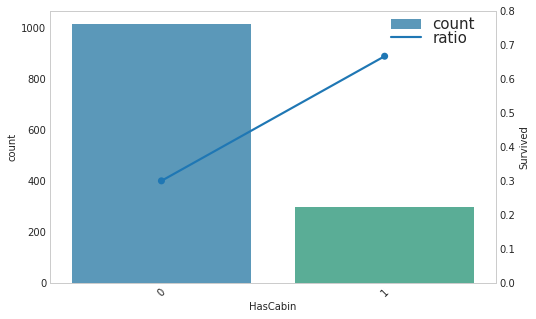

In [36]:
show_count_ratio(combined_test, 'HasCabin', 'Survived', 8, 5)

In [37]:
combined_test[['Survived', 'HasCabin']].corr()

,Survived,HasCabin
Survived,1.000000,0.316912
HasCabin,0.316912,1.000000


- 对于FareFreq没有太明显的规律，不如直接看一下Fare的分布
- test中的Fare有一个空值，用中位数填充

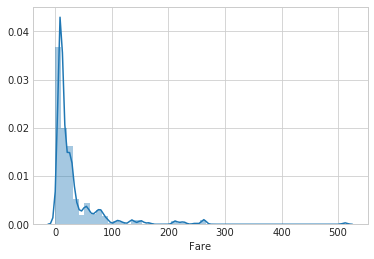

In [38]:
combined_test.loc[combined_test['Fare'].isnull(), 'Fare'] = combined_test.Fare.median()
sns.distplot(combined_test['Fare'])
plt.show()

- 这个图不够平滑，取对数值看看

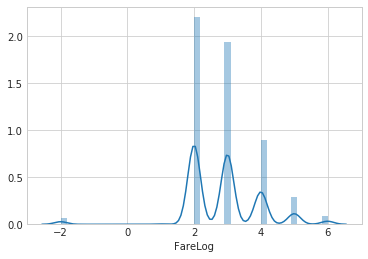

In [39]:
def log_fare(x):
    if x <= 0:
        return np.round(np.log(0.1), 0)
    else:
        return np.round(np.log(x), 0)

combined_test['FareLog'] = combined_test['Fare'].map(log_fare)
sns.distplot(combined_test['FareLog'])
plt.show()

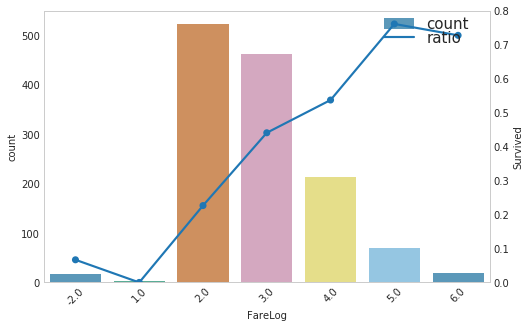

In [40]:
show_count_ratio(combined_test, 'FareLog', 'Survived', 8, 5)

- 对Fare取了Log后，看起来是具有单调性的，干脆再进行一下合并，然后再看下分布和存活概率

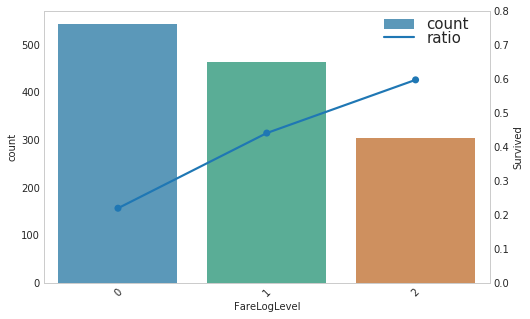

In [41]:
def log_fare_level(x):
    if x <=2:
        return 0
    elif x >= 4:
        return 2
    else:
        return 1

combined_test['FareLogLevel'] = combined_test['FareLog'].map(log_fare_level)
show_count_ratio(combined_test, 'FareLogLevel', 'Survived', 8, 5)

- 如上图所示，好像还可以的样子

### 暂时停车，回顾下现在的情况
- 缺失值情况
- 已有的特征

In [42]:
combined_test.isnull().sum()

Age                 263
Cabin              1014
Embarked              2
Fare                  0
Name                  0
Parch                 0
PassengerId           0
Pclass                0
Sex                   0
SibSp                 0
Survived            418
Ticket                0
Child                 0
SLogR                 0
FirstName             0
FamilySize            0
FirstNameFreq         0
FareFreq              1
TicketFreq            0
CabinFreq          1014
TicketFreqLevel       0
HasCabin              0
FareLog               0
FareLogLevel          0
dtype: int64

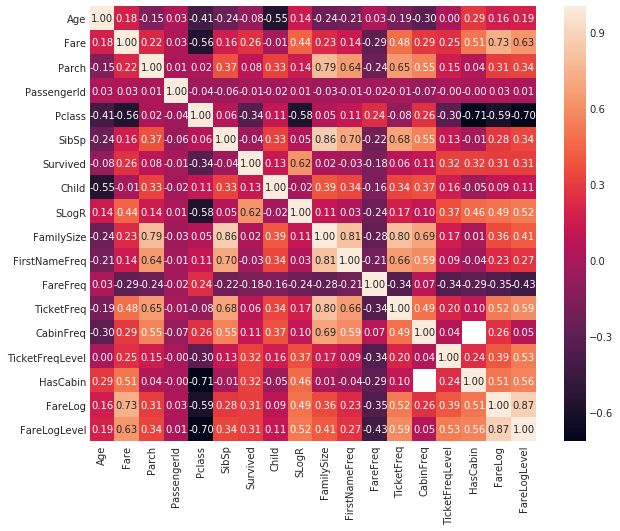

In [43]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
sns.heatmap(combined_test.corr(), annot=True, ax=ax, fmt='.2f')

### Name Title
- 每个乘客的Title可以还提取出来，如Mr,Miss等

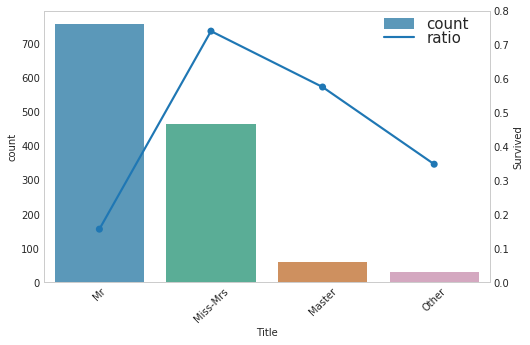

In [44]:
def get_title(x):
    title = x.split(',')[1].split('.')[0].strip()
    if title in ['Mr', 'Master']:
        return title
    elif title in ['Miss', 'Mrs', 'Ms', 'Mme', 'Mlle']:
        return 'Miss-Mrs'
    else:
        return 'Other'

combined_test['Title']=combined_test['Name'].map(get_title)
show_count_ratio(combined_test, 'Title', 'Survived', 8, 5)

- 可以考虑将Miss-Mrs和Master归为一类，Mr和other归为一类

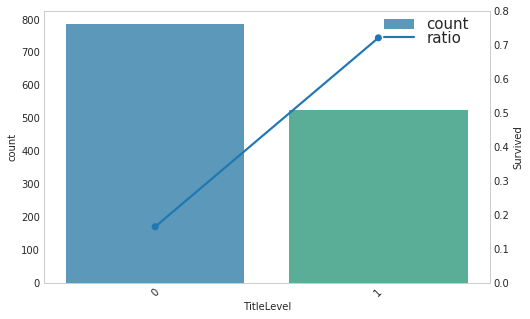

,Survived,TitleLevel
Survived,1.000000,0.558615
TitleLevel,0.558615,1.000000


In [45]:
def title_level(x):
    if x == 'Mr' or x == 'Other':
        return 0
    else:
        return 1

combined_test['TitleLevel']=combined_test['Title'].map(title_level)
show_count_ratio(combined_test, 'TitleLevel', 'Survived', 8, 5)
combined_test[['Survived', 'TitleLevel']].corr()

- 嗯，感觉还阔以，再看看有什么特征可以做

In [46]:
pd.set_option('max_column', 100)
combined_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Child,SLogR,FirstName,FamilySize,FirstNameFreq,FareFreq,TicketFreq,CabinFreq,TicketFreqLevel,HasCabin,FareLog,FareLogLevel,Title,TitleLevel
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False,-1.853635,Braund,2,2,18.0,1,NaN,1,0,2.0,0,Mr,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,False,3.412247,Cumings,2,2,2.0,2,2.0,2,1,4.0,2,Miss-Mrs,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,False,0.000000,Heikkinen,1,1,23.0,1,NaN,1,0,2.0,0,Miss-Mrs,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,False,3.412247,Futrelle,2,2,6.0,2,2.0,2,1,4.0,2,Miss-Mrs,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,False,-1.853635,Allen,1,2,60.0,1,NaN,1,0,2.0,0,Mr,0


In [147]:
x_train = combined_test[:train.shape[0]][['SLogR','TicketFreqLevel','TitleLevel','FareLogLevel']].values
y_train = combined_test[:train.shape[0]]['Survived'].values

## 模型训练

In [155]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import xgboost as xgb

kfold = StratifiedKFold(n_splits=10)

- 大致先看一下xgboost默认参数在cv集上的性能

In [114]:
clf = xgb.XGBClassifier()

accuracy_scores = []
for i in range(n_repeat):
    for train_idx, validate_idx in skf.split(x_train, y_train):
        split_train_x = x_train[train_idx]
        split_train_y = y_train[train_idx]
        clf.fit(split_train_x, split_train_y)
        
        split_validate_x = x_train[validate_idx]
        split_validate_y = y_train[validate_idx]
        
        predict_y = clf.predict(split_validate_x)
        accuracy_scores.append(accuracy_score(split_validate_y, predict_y))
np.array(accuracy_scores).mean()

0.82781823856542958

In [115]:
xgb_clf = xgb.XGBClassifier()
param_grid = {
    'n_estimators': [80,100,120,140,160,180,200],
    'learning_rate': [0.01,0.03,0.1,0.3],
    'subsample':[0.5,0.8,1],
    'max_depth':[2,3,4,5]
}
gs_xgb = GridSearchCV(xgb_clf, param_grid=param_grid,
                      cv=kfold, scoring='accuracy')
gs_xgb.fit(x_train, y_train)
gs_xgb.best_params_

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 180, 'subsample': 0.5}

In [117]:
rf_clf = RandomForestClassifier()
param_grid = {
    'n_estimators': range(100, 150, 5),
    'max_features':[0.5,0.8,1],
    'max_depth':[2,3,4,5]
}
gs_rf = GridSearchCV(rf_clf, param_grid=param_grid,
                     cv=kfold, scoring='accuracy')
gs_rf.fit(x_train, y_train)
gs_rf.best_params_

{'max_depth': 4, 'max_features': 1, 'n_estimators': 110}

In [119]:
gb_clf = GradientBoostingClassifier()
param_grid = {
    'n_estimators': range(80, 160, 10),
    'learning_rate': [0.01,0.03,0.1,0.3],
    'subsample':[0.5,0.8,1],
    'max_depth':[2,3,4,5]
}
gs_gb = GridSearchCV(gb_clf, param_grid=param_grid,
                     cv=kfold, scoring='accuracy')
gs_gb.fit(x_train, y_train)
gs_gb.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 90, 'subsample': 0.5}

### 模型融合之stacking
- sklearn没有集成stacking模块，这里建议使用mlxtend，也是一个不错的机器学习包，还支持在2维特征空间的分类效果展示模块

In [148]:
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier
sclf = StackingClassifier(classifiers=[gs_xgb.best_estimator_,
                                       gs_gb.best_estimator_,
                                       gs_rf.best_estimator_],
                         meta_classifier=LogisticRegression(),
                         use_probas=True, average_probas=False)
scores = cross_val_score(sclf, x_train, y_train, cv=5, scoring='accuracy')

In [152]:
sclf.fit(x_train, y_train)

StackingClassifier(average_probas=False,
          classifiers=[XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=180, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos...imators=110, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)],
          meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          use_features_in_secondary=False, use_probas=True, verbose=0)

In [149]:
scores.mean()

0.80375198552231075

In [150]:
cross_val_score(gs_xgb.best_estimator_, x_train, y_train, cv=5, scoring='accuracy').mean()

0.81827712518711526

In [153]:
x_test = combined_test[train.shape[0]:][['SLogR','TicketFreqLevel','TitleLevel','FareLogLevel']].values

submission = pd.DataFrame({ 'PassengerId': combined[train.shape[0]:]['PassengerId'], 'Survived': sclf.predict(x_test).astype(int)})
submission.to_csv("tt_analysis_stacking.csv", index=False)